In [2]:
from pathlib import Path
import pandas as pd
import gensim, spacy
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from joblib import Memory
from wordcloud import WordCloud
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import plotly.express as px
import pyLDAvis
import pyLDAvis.gensim_models
import warnings
warnings.filterwarnings("ignore")

In [62]:
BASE_DIR = Path.cwd().parent
stop_words = stopwords.words('english')
cachedir = 'cache'
memory = Memory(cachedir, verbose=0)
PALETTE = px.colors.sequential.Plasma

In [4]:
df_hosts_reviews_en = pd.read_parquet(BASE_DIR / 'staging_data' / 'hosts_reviews_en_cleaned.parquet')

In [5]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df_hosts_reviews_en['comments'].values.tolist()
data_words = list(sent_to_words(data))
print(data_words[1])

['nice', 'flat', 'great', 'area', 'host', 'sorted', 'things', 'make', 'stay', 'smooth', 'easy', 'leaving', 'key', 'neighbours', 'etc', 'thanks']


In [6]:
nlp = spacy.load("en_core_web_sm")
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
@memory.cache
def process_words_cached(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    #texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

# call the cached function
data_ready = process_words_cached(data_words)

In [7]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

lda_model.print_topics()

[(0,
  '0.017*"room" + 0.016*"bed" + 0.013*"kitchen" + 0.013*"good" + 0.011*"apartment" + 0.011*"small" + 0.010*"bathroom" + 0.009*"also" + 0.009*"work" + 0.008*"get"'),
 (1,
  '0.103*"host" + 0.050*"stay" + 0.046*"great" + 0.038*"place" + 0.033*"apartment" + 0.031*"location" + 0.027*"nice" + 0.026*"recommend" + 0.023*"clean" + 0.021*"really"'),
 (2,
  '0.035*"apartment" + 0.030*"walk" + 0.028*"close" + 0.021*"station" + 0.019*"city" + 0.018*"restaurant" + 0.018*"great" + 0.016*"stay" + 0.016*"minute" + 0.015*"nice"')]

In [8]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,3), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['dominant_topic', 'percent_contribution', 'topic_keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    contents.name = 'text'
    sent_topics_df = (df_hosts_reviews_en.merge(sent_topics_df, left_index=True, right_index=True)
                                    .merge(contents, left_index=True, right_index=True)
                                    .drop('index', axis=1))
    return(sent_topics_df)


df_dominant_topic = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)
df_dominant_topic.head()

,date,listing_id_encod,listing_id,reviewer_id,reviewer_name,comments,host_id,host_name,host_description,neighbourhood,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,comments_language,description_language,dominant_topic,percent_contribution,topic_keywords,text
0,2010-09-06,0.0,32984.0,200247.0,Keenan,great little apartment perfect spot town nice ...,53396.0,Chris,city hall stockholm beautiful bright 43 sqm 1b...,Kungsholmens,...,4.29,4.52,4.81,4.2,en,en,2,0.626,"apartment, walk, close, station, city, restaur...","[great, little, apartment, perfect, spot, town..."
1,2010-09-12,0.0,32984.0,126543.0,Olaf,nice flat great area host sorted things make s...,53396.0,Chris,city hall stockholm beautiful bright 43 sqm 1b...,Kungsholmens,...,4.29,4.52,4.81,4.2,en,en,1,0.577,"host, stay, great, place, apartment, location,...","[nice, flat, great, area, host, sort, thing, m..."
2,2011-05-21,0.0,32984.0,294223.0,Max,great location host responsive email country t...,53396.0,Chris,city hall stockholm beautiful bright 43 sqm 1b...,Kungsholmens,...,4.29,4.52,4.81,4.2,en,en,0,0.587,"room, bed, kitchen, good, apartment, small, ba...","[great, location, host, responsive, email, cou..."
3,2011-05-28,0.0,32984.0,577190.0,Eli,host place super great close everything quite ...,53396.0,Chris,city hall stockholm beautiful bright 43 sqm 1b...,Kungsholmens,...,4.29,4.52,4.81,4.2,en,en,2,0.591,"apartment, walk, close, station, city, restaur...","[host, place, super, great, close, quite, cent..."
4,2011-06-11,0.0,32984.0,521818.0,Jonathan,nice apartment great location great price host...,53396.0,Chris,city hall stockholm beautiful bright 43 sqm 1b...,Kungsholmens,...,4.29,4.52,4.81,4.2,en,en,1,0.523,"host, stay, great, place, apartment, location,...","[nice, apartment, great, location, great, pric..."


In [9]:
df_dominant_topic.to_parquet(BASE_DIR / 'processed_data' / 'hosts_reviews_en_topics.parquet')

In [10]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.114408  0.187582       1        1  42.226489
2     -0.164892 -0.166263       2        1  30.693204
0      0.279300 -0.021319       3        1  27.080307, topic_info=        Term          Freq         Total Category  logprob  loglift
28      host  60574.000000  60574.000000  Default  30.0000  30.0000
24      walk  12572.000000  12572.000000  Default  29.0000  29.0000
70     close  11641.000000  11641.000000  Default  28.0000  28.0000
8      great  33836.000000  33836.000000  Default  27.0000  27.0000
156  station   8649.000000   8649.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
38     clean   2574.186986  19358.530266   Topic3  -4.9719  -0.7112
89     check   1955.293412   5315.184054   Topic3  -5.2468   0.3063
35      stay   2539.080113  38400.345309   Topic3  -4.9856  -1.4099
186     find   1790.976863   3267.127704   Topic3  -5.3346   0.7052
50      need   1986.762140  12047.628630   Topic3  -5.2309  -0.4960

[200 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
642       1  0.984610  accommodate
642       2  0.001427  accommodate
642       3  0.014270  accommodate
410       1  0.996498       advice
246       1  0.241857         also
...     ...       ...          ...
158       3  0.131322         well
606       2  0.000955         wifi
606       3  0.999601         wifi
886       3  0.999407       window
620       3  0.999763         work

[248 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

In [11]:
topics = lda_model.show_topics(formatted=False)

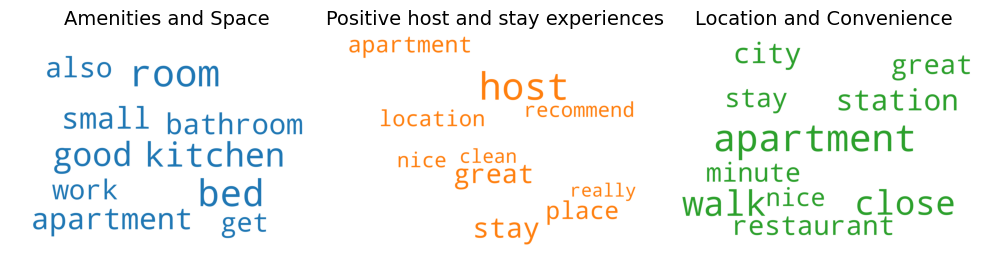

In [12]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

fig, axes = plt.subplots(1, 3, figsize=(10,10), sharex=True, sharey=True)

groups = ['Amenities and Space',
        'Positive host and stay experiences',
        'Location and Convenience']

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title(groups[i], fontdict=dict(size=14))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=5, hspace=5)
plt.axis('off')
#plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [58]:
avg_topic_by_neighbourhood = (df_dominant_topic.groupby(['neighbourhood'])
        .agg(avg_topic=('dominant_topic', 'mean'))
        .sort_values('avg_topic', ascending=False)
        .reset_index())
avg_topic_by_neighbourhood

,neighbourhood,avg_topic
0,Bromma,1.206388
1,Farsta,1.172527
2,Hägersten-Liljeholmens,1.162840
3,Skarpnäcks,1.159162
4,Älvsjö,1.142544
5,Enskede-Årsta-Vantörs,1.141199
6,Östermalms,1.115136
7,Södermalms,1.112989
8,Hässelby-Vällingby,1.108722
9,Spånga-Tensta,1.074586


In [59]:
px.density_heatmap(avg_topic_by_neighbourhood,
                   x='neighbourhood', y='avg_topic')

In [53]:
numnber_topic_by_neighbourhood = (df_dominant_topic.groupby(['neighbourhood', 'dominant_topic'])
        .agg(number_of_reviews=('number_of_reviews', 'count'))
        .sort_values('number_of_reviews', ascending=False)
        .reset_index())
numnber_topic_by_neighbourhood 

,neighbourhood,dominant_topic,number_of_reviews
0,Södermalms,1,18553
1,Södermalms,2,8735
2,Södermalms,0,5078
3,Kungsholmens,1,4908
4,Norrmalms,1,4600
5,Östermalms,1,2936
6,Enskede-Årsta-Vantörs,1,2570
7,Hägersten-Liljeholmens,1,2352
8,Kungsholmens,2,1643
9,Norrmalms,2,1619


In [64]:
px.treemap(numnber_topic_by_neighbourhood , path=['neighbourhood', 'dominant_topic'], values='number_of_reviews',
           color_continuous_scale=PALETTE)